<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# PyTorch Gradients
This section covers the PyTorch <a href='https://pytorch.org/docs/stable/autograd.html'><strong><tt>autograd</tt></strong></a> implementation of gradient descent. Tools include:
* <a href='https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward'><tt><strong>torch.autograd.backward()</strong></tt></a>
* <a href='https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad'><tt><strong>torch.autograd.grad()</strong></tt></a>

Before continuing in this section, be sure to watch the theory lectures to understand the following concepts:
* Error functions (step and sigmoid)
* One-hot encoding
* Maximum likelihood
* Cross entropy (including multi-class cross entropy)
* Back propagation (backprop)

<div class="alert alert-info"><h3>Additional Resources:</h3>
<strong>
<a href='https://pytorch.org/docs/stable/notes/autograd.html'>PyTorch Notes:</a></strong>&nbsp;&nbsp;<font color=black>Autograd mechanics</font></div>

## Autograd - Automatic Differentiation
In previous sections we created tensors and performed a variety of operations on them, but we did nothing to store the sequence of operations, or to apply the derivative of a completed function.

In this section we'll introduce the concept of the <em>dynamic computational graph</em> which is comprised of all the <em>Tensor</em> objects in the network, as well as the <em>Functions</em> used to create them. Note that only the input Tensors we create ourselves will not have associated Function objects.

The PyTorch <a href='https://pytorch.org/docs/stable/autograd.html'><strong><tt>autograd</tt></strong></a> package provides automatic differentiation for all operations on Tensors. This is because operations become attributes of the tensors themselves. When a Tensor's <tt>.requires_grad</tt> attribute is set to True, it starts to track all operations on it. When an operation finishes you can call <tt>.backward()</tt> and have all the gradients computed automatically. The gradient for a tensor will be accumulated into its <tt>.grad</tt> attribute.
    
Let's see this in practice.

## Back-propagation on one step
We'll start by applying a single polynomial function $y = f(x)$ to tensor $x$. Then we'll backprop and print the gradient $\frac {dy} {dx}$.

$\begin{split}Function:\quad y &= 2x^4 + x^3 + 3x^2 + 5x + 1 \\
Derivative:\quad y' &= 8x^3 + 3x^2 + 6x + 5\end{split}$

#### Step 1. Perform standard imports

In [1]:
import torch

#### Step 2. Create a tensor with <tt>requires_grad</tt> set to True
This sets up computational tracking on the tensor.

In [2]:
x = torch.tensor(2.0, requires_grad=True)

#### Step 3. Define a function

In [3]:
y = 2*x**4 + x**3 + 3*x**2 + 5*x + 1

print(y)

tensor(63., grad_fn=<AddBackward0>)


Since $y$ was created as a result of an operation, it has an associated gradient function accessible as <tt>y.grad_fn</tt><br>
The calculation of $y$ is done as:<br>

$\quad y=2(2)^4+(2)^3+3(2)^2+5(2)+1 = 32+8+12+10+1 = 63$

This is the value of $y$ when $x=2$.

#### Step 4. Backprop

In [4]:
y.backward()

#### Step 5. Display the resulting gradient

In [5]:
print(x.grad)

tensor(93.)


Note that <tt>x.grad</tt> is an attribute of tensor $x$, so we don't use parentheses. The computation is the result of<br>

$\quad y'=8(2)^3+3(2)^2+6(2)+5 = 64+12+12+5 = 93$

This is the slope of the polynomial at the point $(2,63)$.

## Back-propagation on multiple steps
Now let's do something more complex, involving layers $y$ and $z$ between $x$ and our output layer $out$.
#### 1. Create a tensor

In [6]:
x = torch.tensor([[1.,2,3],[3,2,1]], requires_grad=True)
print(x)

tensor([[1., 2., 3.],
        [3., 2., 1.]], requires_grad=True)


#### 2. Create the first layer with $y = 3x+2$

In [7]:
y = 3*x + 2
print(y)

tensor([[ 5.,  8., 11.],
        [11.,  8.,  5.]], grad_fn=<AddBackward0>)


#### 3. Create the second layer with $z = 2y^2$

In [8]:
z = 2*y**2
print(z)

tensor([[ 50., 128., 242.],
        [242., 128.,  50.]], grad_fn=<MulBackward0>)


#### 4. Set the output to be the matrix mean

In [9]:
out = z.mean()
print(out)

tensor(140., grad_fn=<MeanBackward1>)


#### 5. Now perform back-propagation to find the gradient of x w.r.t out
(If you haven't seen it before, w.r.t. is an abbreviation of <em>with respect to</em>)

In [10]:
out.backward()
print(x.grad)

tensor([[10., 16., 22.],
        [22., 16., 10.]])


You should see a 2x3 matrix. If we call the final <tt>out</tt> tensor "$o$", we can calculate the partial derivative of $o$ with respect to $x_i$ as follows:<br>

$o = \frac {1} {6}\sum_{i=1}^{6} z_i$<br>

$z_i = 2(y_i)^2 = 2(3x_i+2)^2$<br>

To solve the derivative of $z_i$ we use the <a href='https://en.wikipedia.org/wiki/Chain_rule'>chain rule</a>, where the derivative of $f(g(x)) = f'(g(x))g'(x)$<br>

In this case<br>

$\begin{split} f(g(x)) &= 2(g(x))^2, \quad &f'(g(x)) = 4g(x) \\
g(x) &= 3x+2, &g'(x) = 3 \\
\frac {dz} {dx} &= 4g(x)\times 3 &= 12(3x+2) \end{split}$

Therefore,<br>

$\frac{\partial o}{\partial x_i} = \frac{1}{6}\times 12(3x+2)$<br>

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = 2(3(1)+2) = 10$

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=2} = 2(3(2)+2) = 16$

$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=3} = 2(3(3)+2) = 22$

## Turn off tracking
There may be times when we don't want or need to track the computational history.

You can reset a tensor's <tt>requires_grad</tt> attribute in-place using `.requires_grad_(True)` (or False) as needed.

When performing evaluations, it's often helpful to wrap a set of operations in `with torch.no_grad():`

A less-used method is to run `.detach()` on a tensor to prevent future computations from being tracked. This can be handy when cloning a tensor.

<div class="alert alert-info"><strong>A NOTE ABOUT TENSORS AND VARIABLES:</strong> Prior to PyTorch v0.4.0 (April 2018) Tensors (<tt>torch.Tensor</tt>) only held data, and tracking history was reserved for the Variable wrapper (<tt>torch.autograd.Variable</tt>). Since v0.4.0 tensors and variables have merged, and tracking functionality is now available through the <tt>requires_grad=True</tt> flag.</div>

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Linear Regression with PyTorch
In this section we'll use PyTorch's machine learning model to progressively develop a best-fit line for a given set of data points. Like most linear regression algorithms, we're seeking to minimize the error between our model and the actual data, using a <em>loss function</em> like mean-squared-error.

<img src='../Images/linear-regression-residuals.png' width='400' style="display: inline-block"><br>

Image source: <a href='https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png'>https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png</a>

To start, we'll develop a collection of data points that appear random, but that fit a known linear equation $y = 2x+1$

## Perform standard imports

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create a column matrix of X values
We can create tensors right away rather than convert from NumPy arrays.

In [2]:
X = torch.linspace(1,50,50).reshape(-1,1)

# Equivalent to
# X = torch.unsqueeze(torch.linspace(1,50,50), dim=1)

## Create a "random" array of error values
We want 50 random integer values that collectively cancel each other out.

In [3]:
torch.manual_seed(71) # to obtain reproducible results
e = torch.randint(-8,9,(50,1),dtype=torch.float)
print(e.sum())

tensor(0.)


## Create a column matrix of y values
Here we'll set our own parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$, plus the error amount.<br><strong><tt>y</tt></strong> will have the same shape as <strong><tt>X</tt></strong> and <strong><tt>e</tt></strong>

In [4]:
y = 2*X + 1 + e
print(y.shape)

torch.Size([50, 1])


## Plot the results
We have to convert tensors to NumPy arrays just for plotting.

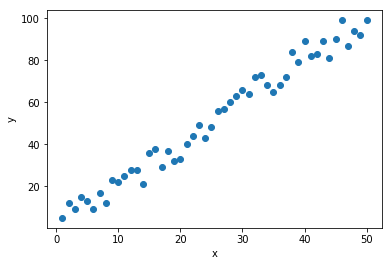

In [5]:
plt.scatter(X.numpy(), y.numpy())
plt.ylabel('y')
plt.xlabel('x');

Note that when we created tensor $X$, we did <em>not</em> pass <tt>requires_grad=True</tt>. This means that $y$ doesn't have a gradient function, and <tt>y.backward()</tt> won't work. Since PyTorch is not tracking operations, it doesn't know the relationship between $X$ and $y$.

## Simple linear model
As a quick demonstration we'll show how the built-in <tt>nn.Linear()</tt> model preselects weight and bias values at random.

In [6]:
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


Without seeing any data, the model sets a random weight of 0.1060 and a bias of 0.9638.

## Model classes
PyTorch lets us define models as object classes that can store multiple model layers. In upcoming sections we'll set up several neural network layers, and determine how each layer should perform its forward pass to the next layer. For now, though, we only need a single <tt>linear</tt> layer.

In [7]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

<div class="alert alert-info"><strong>NOTE:</strong> The "Linear" model layer used here doesn't really refer to linear regression. Instead, it describes the type of neural network layer employed. Linear layers are also called "fully connected" or "dense" layers. Going forward our models may contain linear layers, convolutional layers, and more.</div>

When <tt>Model</tt> is instantiated, we need to pass in the size (dimensions) of the incoming and outgoing features. For our purposes we'll use (1,1).<br>As above, we can see the initial hyperparameters.

In [8]:
torch.manual_seed(59)
model = Model(1, 1)
print(model)
print('Weight:', model.linear.weight.item())
print('Bias:  ', model.linear.bias.item())

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Weight: 0.10597813129425049
Bias:   0.9637961387634277


As models become more complex, it may be better to iterate over all the model parameters:

In [9]:
for name, param in model.named_parameters():
    print(name, '\t', param.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


<div class="alert alert-info"><strong>NOTE:</strong> In the above example we had our Model class accept arguments for the number of input and output features.<br>For simplicity we can hardcode them into the Model:
         
<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(1,1)<br><br>
model = Model()
</font></tt><br><br>

Alternatively we can use default arguments:

<tt><font color=black>
class Model(torch.nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, in_dim=1, out_dim=1):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;self.linear = Linear(in_dim,out_dim)<br><br>
model = Model()<br>
<em>\# or</em><br>
model = Model(i,o)</font></tt>
</div>

Now let's see the result when we pass a tensor into the model.

In [10]:
x = torch.tensor([2.0])
print(model.forward(x))   # equivalent to print(model(x))

tensor([1.1758], grad_fn=<AddBackward0>)


which is confirmed with $f(x) = (0.1060)(2.0)+(0.9638) = 1.1758$

## Plot the initial model
We can plot the untrained model against our dataset to get an idea of our starting point.

In [11]:
x1 = np.array([X.min(),X.max()])
print(x1)

[ 1. 50.]


In [12]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Initial weight: {w1:.8f}, Initial bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(y1)

Initial weight: 0.10597813, Initial bias: 0.96379614

[1.0697743 6.2627025]


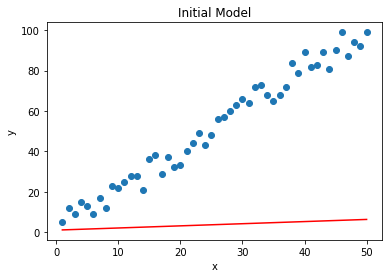

In [13]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Initial Model')
plt.ylabel('y')
plt.xlabel('x');

## Set the loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows<br>

$\begin{split}MSE &= \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 \\
&= \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\end{split}$<br>

Fortunately PyTorch has it built in.<br>
<em>By convention, you'll see the variable name "criterion" used, but feel free to use something like "linear_loss_func" if that's clearer.</em>

In [14]:
criterion = nn.MSELoss()

## Set the optimization
Here we'll use <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic Gradient Descent</a> (SGD) with an applied <a href='https://en.wikipedia.org/wiki/Learning_rate'>learning rate</a> (lr) of 0.001. Recall that the learning rate tells the optimizer how much to adjust each parameter on the next round of calculations. Too large a step and we run the risk of overshooting the minimum, causing the algorithm to diverge. Too small and it will take a long time to converge.

For more complicated (multivariate) data, you might also consider passing optional <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> and <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a> arguments. Momentum allows the algorithm to "roll over" small bumps to avoid local minima that can cause convergence too soon. Weight decay (also called an L2 penalty) applies to biases.

For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

# You'll sometimes see this as
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

## Train the model
An <em>epoch</em> is a single pass through the entire dataset. We want to pick a sufficiently large number of epochs to reach a plateau close to our known parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take:</strong><br>

1. Set a reasonably large number of passes<br>
<tt><font color=black>epochs = 50</font></tt><br>
2. Create a list to store loss values. This will let us view our progress afterward.<br>
<tt><font color=black>losses = []</font></tt><br>
<tt><font color=black>for i in range(epochs):</font></tt><br>
3. Bump "i" so that the printed report starts at 1<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;i+=1</font></tt><br>
4. Create a prediction set by running "X" through the current model parameters<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;y_pred = model.forward(X)</font></tt><br>
5. Calculate the loss<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;loss = criterion(y_pred, y)</font></tt><br>
6. Add the loss value to our tracking list<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;losses.append(loss)</font></tt><br>
7. Print the current line of results<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;print(f'epoch: {i:2} loss: {loss.item():10.8f}')</font></tt><br>
8. Gradients accumulate with every backprop. To prevent compounding we need to reset the stored gradient for each new epoch.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;optimizer.zero_grad()</font></tt><br>
9. Now we can backprop<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;loss.backward()</font></tt><br>
10. Finally, we can update the hyperparameters of our model<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;optimizer.step()</font></tt>
</div>

In [16]:
epochs = 50
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X)
    loss = criterion(y_pred, y)
    losses.append(loss)
    print(f'epoch: {i:2}  loss: {loss.item():10.8f}  weight: {model.linear.weight.item():10.8f}  \
bias: {model.linear.bias.item():10.8f}') 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 3057.21679688  weight: 0.10597813  bias: 0.96379614
epoch:  2  loss: 1588.53100586  weight: 3.33490038  bias: 1.06046367
epoch:  3  loss: 830.30010986  weight: 1.01483274  bias: 0.99226278
epoch:  4  loss: 438.85241699  weight: 2.68179965  bias: 1.04252183
epoch:  5  loss: 236.76152039  weight: 1.48402119  bias: 1.00766504
epoch:  6  loss: 132.42912292  weight: 2.34460592  bias: 1.03396463
epoch:  7  loss: 78.56572723  weight: 1.72622538  bias: 1.01632178
epoch:  8  loss: 50.75775909  weight: 2.17050409  bias: 1.03025162
epoch:  9  loss: 36.40123367  weight: 1.85124576  bias: 1.02149546
epoch: 10  loss: 28.98922729  weight: 2.08060074  bias: 1.02903891
epoch: 11  loss: 25.16238213  weight: 1.91576838  bias: 1.02487016
epoch: 12  loss: 23.18647385  weight: 2.03416562  bias: 1.02911627
epoch: 13  loss: 22.16612816  weight: 1.94905841  bias: 1.02731562
epoch: 14  loss: 21.63911057  weight: 2.01017213  bias: 1.02985907
epoch: 15  loss: 21.36677170  weight: 1.96622372  bias

## Plot the loss values
Let's see how loss changed over time

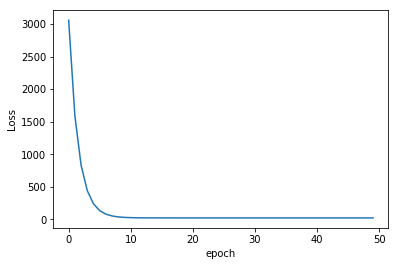

In [17]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

## Plot the result
Now we'll derive <tt>y1</tt> from the new model to plot the most recent best-fit line.

In [18]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Current weight: {w1:.8f}, Current bias: {b1:.8f}')
print()

y1 = x1*w1 + b1
print(x1)
print(y1)

Current weight: 1.98381913, Current bias: 1.05575156

[ 1. 50.]
[  3.0395708 100.246704 ]


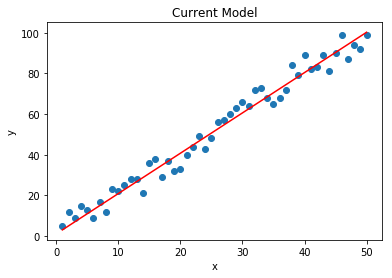

In [19]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1,y1,'r')
plt.title('Current Model')
plt.ylabel('y')
plt.xlabel('x');

## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Datasets with PyTorch
In this section we'll show how to:
* load data from outside files
* build random batches using PyTorch's <a href='https://pytorch.org/docs/stable/data.html'><strong><tt>data</tt></strong></a> utilities<br>

At the end we'll briefly mention <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>.

## Perform standard imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data from files
We've seen how to load NumPy arrays into PyTorch, and anyone familiar with <tt>pandas.read_csv()</tt> can use it to prepare data before forming tensors. Here we'll load the <a href='https://en.wikipedia.org/wiki/Iris_flower_data_set'>iris flower dataset</a> saved as a .csv file.

In [2]:
df = pd.read_csv('../Data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [3]:
df.shape

(150, 5)

## Plot the data

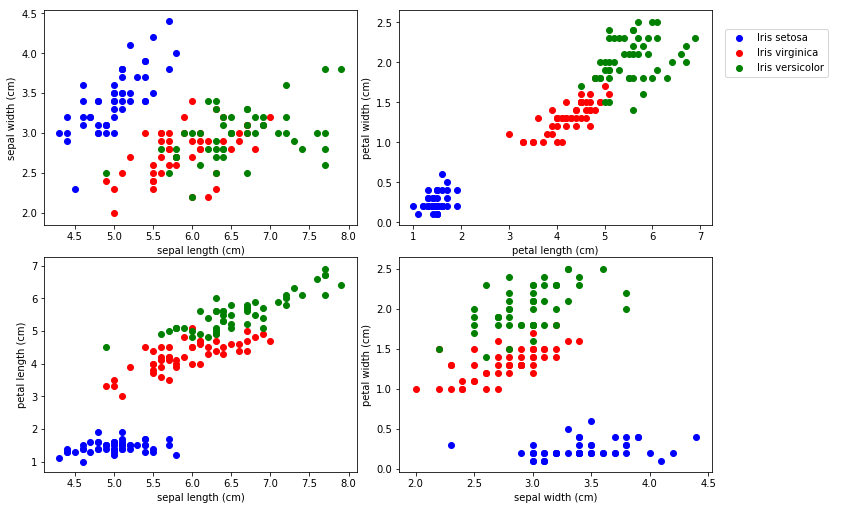

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

The iris dataset consists of 50 samples each from three species of Iris (<em>Iris setosa</em>, <em>Iris virginica</em> and <em>Iris versicolor</em>), for 150 total samples. We have four features (sepal length & width, petal length & width) and three unique labels:
0. <em>Iris setosa</em>
1. <em>Iris virginica</em>
2. <em>Iris versicolor</em>

### The classic method for building train/test split tensors
Before introducing PyTorch's Dataset and DataLoader classes, we'll take a quick look at the alternative.

In [5]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df.drop('target',axis=1).values,
                                                    df['target'].values, test_size=0.2,
                                                    random_state=33)

X_train = torch.FloatTensor(train_X)
X_test = torch.FloatTensor(test_X)
y_train = torch.LongTensor(train_y).reshape(-1, 1)
y_test = torch.LongTensor(test_y).reshape(-1, 1)

In [6]:
print(f'Training size: {len(y_train)}')
labels, counts = y_train.unique(return_counts=True)
print(f'Labels: {labels}\nCounts: {counts}')

Training size: 120
Labels: tensor([0, 1, 2])
Counts: tensor([42, 42, 36])


<div class="alert alert-success"><strong>NOTE: </strong>The importance of a balanced training set is discussed in <em>A systematic study of the class imbalance problem in convolutional neural networks</em> by Mateusz Buda, Atsuto Maki, Maciej A. Mazurowski (10/15/17, latest rev 10/13/18) <a href='https://arxiv.org/abs/1710.05381'>https://arxiv.org/abs/1710.05381</a><br>For example, the authors show that oversampling a less common class so that it matches the more common classes is always the preferred choice.</div>

In [7]:
X_train.size()

torch.Size([120, 4])

In [8]:
y_train.size()

torch.Size([120, 1])

<div class="alert alert-info"><strong>NOTE: </strong>It's up to us to remember which columns correspond to which features.</div>

## Using PyTorch's Dataset and DataLoader classes
A far better alternative is to leverage PyTorch's <a href='https://pytorch.org/docs/stable/data.html'><strong><tt>Dataset</tt></strong></a> and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><strong><tt>DataLoader</strong></tt></a> classes.

Usually, to set up a Dataset specific to our investigation we would define our own custom class that inherits from <tt>torch.utils.data.Dataset</tt> (we'll do this in the CNN section). For now, we can use the built-in <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset'><strong><tt>TensorDataset</tt></strong></a> class.

In [9]:
from torch.utils.data import TensorDataset, DataLoader

data = df.drop('target',axis=1).values
labels = df['target'].values

iris = TensorDataset(torch.FloatTensor(data),torch.LongTensor(labels))

In [10]:
len(iris)

150

In [11]:
type(iris)

torch.utils.data.dataset.TensorDataset

In [12]:
for i in iris:
    print(i)

(tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))
(tensor([4.9000, 3.0000, 1.4000, 0.2000]), tensor(0))
(tensor([4.7000, 3.2000, 1.3000, 0.2000]), tensor(0))
(tensor([4.6000, 3.1000, 1.5000, 0.2000]), tensor(0))
(tensor([5.0000, 3.6000, 1.4000, 0.2000]), tensor(0))
(tensor([5.4000, 3.9000, 1.7000, 0.4000]), tensor(0))
(tensor([4.6000, 3.4000, 1.4000, 0.3000]), tensor(0))
(tensor([5.0000, 3.4000, 1.5000, 0.2000]), tensor(0))
(tensor([4.4000, 2.9000, 1.4000, 0.2000]), tensor(0))
(tensor([4.9000, 3.1000, 1.5000, 0.1000]), tensor(0))
(tensor([5.4000, 3.7000, 1.5000, 0.2000]), tensor(0))
(tensor([4.8000, 3.4000, 1.6000, 0.2000]), tensor(0))
(tensor([4.8000, 3.0000, 1.4000, 0.1000]), tensor(0))
(tensor([4.3000, 3.0000, 1.1000, 0.1000]), tensor(0))
(tensor([5.8000, 4.0000, 1.2000, 0.2000]), tensor(0))
(tensor([5.7000, 4.4000, 1.5000, 0.4000]), tensor(0))
(tensor([5.4000, 3.9000, 1.3000, 0.4000]), tensor(0))
(tensor([5.1000, 3.5000, 1.4000, 0.3000]), tensor(0))
(tensor([5.7000, 3.8000, 1.7

Once we have a dataset we can wrap it with a DataLoader. This gives us a powerful sampler that provides single- or multi-process iterators over the dataset.

In [14]:
iris_loader = DataLoader(iris, batch_size=105, shuffle=True)

In [15]:
for i_batch, sample_batched in enumerate(iris_loader):
    print(i_batch, sample_batched)

0 [tensor([[6.7000, 3.1000, 4.4000, 1.4000],
        [4.8000, 3.4000, 1.6000, 0.2000],
        [4.8000, 3.4000, 1.9000, 0.2000],
        [5.6000, 2.9000, 3.6000, 1.3000],
        [6.7000, 3.3000, 5.7000, 2.1000],
        [6.9000, 3.1000, 4.9000, 1.5000],
        [6.7000, 2.5000, 5.8000, 1.8000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [6.7000, 3.1000, 5.6000, 2.4000],
        [5.5000, 2.5000, 4.0000, 1.3000],
        [7.0000, 3.2000, 4.7000, 1.4000],
        [5.5000, 4.2000, 1.4000, 0.2000],
        [7.3000, 2.9000, 6.3000, 1.8000],
        [7.7000, 2.8000, 6.7000, 2.0000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [7.2000, 3.0000, 5.8000, 1.6000],
        [6.7000, 3.1000, 4.7000, 1.5000],
        [5.8000, 2.7000, 3.9000, 1.2000],
        [5.5000, 2.4000, 3.8000, 1.1000],
        [5.0000, 3.5000, 1.6000, 0.6000],
        [5.1000, 3.8000, 1.6000, 0.2000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [6.5000, 3.0000, 5.5000, 1.8000],
        [6.7000, 3.0000, 5.2000

In [16]:
list(iris_loader)[0][1].bincount()

tensor([30, 36, 39])

In [17]:
next(iter(iris_loader))

[tensor([[5.4000, 3.7000, 1.5000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [6.1000, 3.0000, 4.6000, 1.4000],
         [4.3000, 3.0000, 1.1000, 0.1000],
         [5.0000, 3.5000, 1.3000, 0.3000],
         [7.2000, 3.2000, 6.0000, 1.8000],
         [4.8000, 3.4000, 1.9000, 0.2000],
         [6.4000, 3.1000, 5.5000, 1.8000],
         [6.6000, 3.0000, 4.4000, 1.4000],
         [6.8000, 3.2000, 5.9000, 2.3000],
         [6.4000, 3.2000, 4.5000, 1.5000],
         [5.0000, 2.3000, 3.3000, 1.0000],
         [6.0000, 2.2000, 4.0000, 1.0000],
         [6.7000, 3.1000, 5.6000, 2.4000],
         [6.0000, 2.7000, 5.1000, 1.6000],
         [6.2000, 2.8000, 4.8000, 1.8000],
         [5.4000, 3.4000, 1.7000, 0.2000],
         [5.4000, 3.9000, 1.7000, 0.4000],
         [4.6000, 3.2000, 1.4000, 0.2000],
         [5.2000, 2.7000, 3.9000, 1.4000],
         [6.0000, 3.0000, 4.8000, 1.8000],
         [5.7000, 2.8000, 4.5000, 1.3000],
         [7.7000, 2.6000, 6.9000, 2.3000],
         [5

## A Quick Note on Torchvision
PyTorch offers another powerful dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>, which is useful when working with image data. We'll go into a lot more detail in the Convolutional Neural Network (CNN) section. For now, just know that torchvision offers built-in image datasets like <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST</a> and <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a>, as well as tools for transforming images into tensors.

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Basic PyTorch Neural Network
Now it's time to put the pieces together. In this section we'll:
* create a multi-layer deep learning model
* load data
* train and validate the model<br>

We'll also introduce a new step:
* save and load a trained model

Our goal is to develop a model capable of classifying an iris plant based on four features. This is a multi-class classification where each sample can belong to ONE of 3 classes (<em>Iris setosa</em>, <em>Iris virginica</em> or <em>Iris versicolor</em>). The network will have 4 input neurons (flower dimensions) and 3 output neurons (scores). Our loss function will compare the target label (ground truth) to the corresponding output score. 

<div class="alert alert-info"><strong>NOTE:</strong> Multi-class classifications usually involve converting the target vector to a one_hot encoded matrix. That is, if 5 labels show up as<br>
<pre style='background-color:rgb(217,237,247)'>tensor([0,2,1,0,1])</pre>
then we would encode them as:
<pre style='background-color:rgb(217,237,247)'>tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]])</pre>
This is easily accomplished with <a href='https://pytorch.org/docs/stable/nn.html#one-hot'><strong><tt>torch.nn.functional.one_hot()</tt></strong></a>.<br>
However, our loss function <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a> takes care of this for us.</div>

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create a model class
For this exercise we're using the Iris dataset. Since a single straight line can't classify three flowers we should include at least one hidden layer in our model.

In the forward section we'll use the <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'>rectified linear unit</a> (ReLU)  function<br>
$\quad f(x)=max(0,x)$<br>
as our activation function. This is available as a full module <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong><tt>torch.nn.ReLU</tt></strong></a> or as just a functional call <a href='https://pytorch.org/docs/stable/nn.html#id27'><strong><tt>torch.nn.functional.relu</tt></strong></a>

In [2]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [3]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(32)
model = Model()

## Load the iris dataset

In [4]:
df = pd.read_csv('../Data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Plot the dataset
The iris dataset has 4 features. To get an idea how they correlate we can plot four different relationships among them.<br>
We'll use the index positions of the columns to grab their names in pairs with <tt>plots = [(0,1),(2,3),(0,2),(1,3)]</tt>.<br>
Here <tt>(0,1)</tt> sets "sepal length (cm)" as <tt>x</tt> and "sepal width (cm)" as <tt>y</tt>

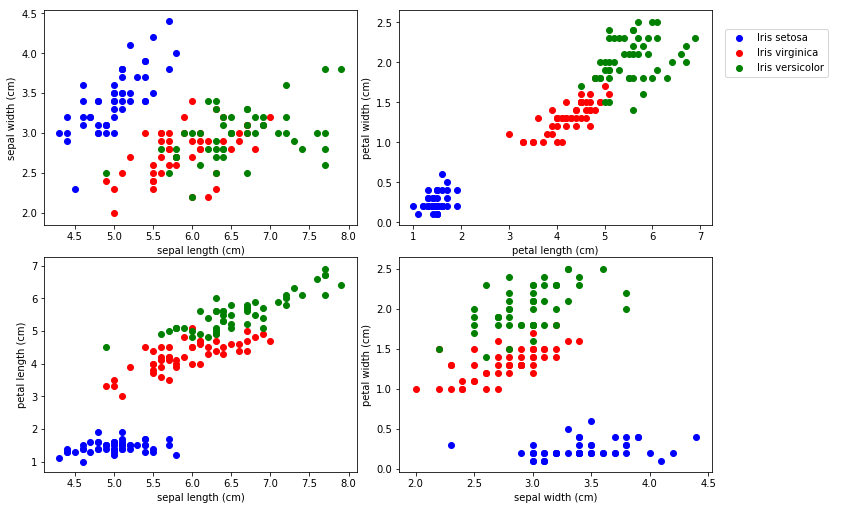

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Perform Train/Test/Split

In [6]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# y_train = F.one_hot(torch.LongTensor(y_train))  # not needed with Cross Entropy Loss
# y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Prepare DataLoader
For this analysis we don't need to create a Dataset object, but we should take advantage of PyTorch's DataLoader tool. Even though our dataset is small (120 training samples), we'll load it into our model in two batches. This technique becomes very helpful with large datasets.

Note that scikit-learn already shuffled the source dataset before preparing train and test sets. We'll still benefit from the DataLoader shuffle utility for model training if we make multiple passes throught the dataset.

In [7]:
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)

testloader = DataLoader(X_test, batch_size=60, shuffle=False)

## Define loss equations and optimizations
As before, we'll utilize <a href='https://en.wikipedia.org/wiki/Cross_entropy'>Cross Entropy</a> with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll use a variation of Stochastic Gradient Descent called <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (short for Adaptive Moment Estimation), with <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [8]:
# FOR REDO
torch.manual_seed(4)
model = Model()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train the model

In [10]:
epochs = 100
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 1.09568226
epoch: 11  loss: 0.98190653
epoch: 21  loss: 0.75652307
epoch: 31  loss: 0.49447522
epoch: 41  loss: 0.34981874
epoch: 51  loss: 0.22807853
epoch: 61  loss: 0.13547322
epoch: 71  loss: 0.09162075
epoch: 81  loss: 0.07378192
epoch: 91  loss: 0.06546164


## Plot the loss function

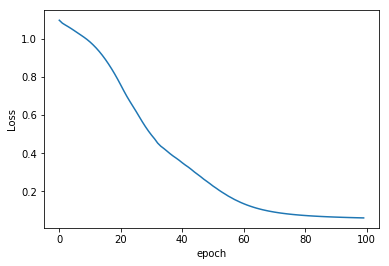

In [11]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

## Validate the model
Now we run the test set through the model to see if the loss calculation resembles the training data.

In [12]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06246195


In [13]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([-0.3355,  7.3630,  1.3783])     1
 2. tensor([0.2775, 8.1554, 0.4269])        1
 3. tensor([ 11.9969,   6.1847, -19.1976])  0
 4. tensor([-2.0187,  7.9664,  4.2447])     1
 5. tensor([-6.1348,  7.9516, 11.0913])     2
 6. tensor([-10.2635,   8.3101,  17.9998])  2
 7. tensor([ 12.0542,   6.4321, -19.2909])  0
 8. tensor([ 12.9507,   6.4819, -20.7540])  0
 9. tensor([-5.7723,  8.2435, 10.5083])     2
10. tensor([-7.8867,  8.6126, 14.0731])     2
11. tensor([-8.7055,  8.6074, 15.4337])     2
12. tensor([ 11.6358,   5.8167, -18.6220])  0
13. tensor([-8.1009,  8.2331, 14.3888])     2
14. tensor([-2.0791,  7.7752,  4.3188])     1
15. tensor([-6.0828,  8.3916, 11.0586])     2
16. tensor([0.1360, 7.8660, 0.6409])        1
17. tensor([-4.0875,  7.7217,  7.6642])     2
18. tensor([ 13.1522,   6.5911, -21.0798])  0
19. tensor([-1.5644,  8.0222,  3.4754])     1
20. tensor([-6.2859,  8.9728, 11.4248])     2
21. tensor([ 12.3859,   6.2571, -19.8275])  0
22. tensor([ 13.8200,   7.0859, -2

Here we can see that #17 was misclassified.

## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html

### Save the model

In [14]:
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

### Load a new model
We'll load a new model object and test it as we had before to make sure it worked.

In [15]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [16]:
with torch.no_grad():
    y_val = new_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06246195


## Apply the model to classify new, unseen data

In [17]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

Let's plot this new iris in yellow to see where it falls in relation to the others:

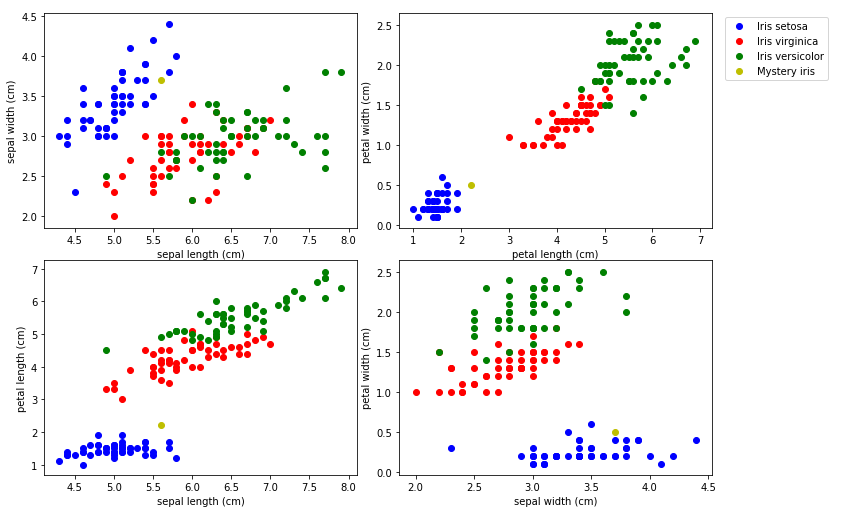

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

Now run it through the model:

In [19]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print()
    print(labels[new_model(mystery_iris).argmax()])

tensor([ 12.2116,   7.1285, -19.5247])

Iris setosa


## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Full Artificial Neural Network Code Along
In the last section we took in four continuous variables (lengths) to perform a classification. In this section we'll combine continuous and categorical data to perform a regression. The goal is to estimate the cost of a New York City cab ride from several inputs. The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

<div class="alert alert-success"><strong>NOTE:</strong> In this notebook we'll perform a regression with one output value. In the next one we'll perform a binary classification with two output values.</div>

## Working with tabular data
Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones. Make sure to watch the theory lectures! You'll want to be comfortable with:
* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

Let's get started!

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Separate categorical from continuous columns

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

<div class="alert alert-info"><strong>NOTE:</strong> If you plan to use all of the columns in the data table, there's a shortcut to grab the remaining continuous columns:<br>
<pre style='background-color:rgb(217,237,247)'>cont_cols = [col for col in df.columns if col not in cat_cols + y_col]</pre>

Here we entered the continuous columns explicitly because there are columns we're not running through the model (pickup_datetime and EDTdate)</div>


## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [11]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

We can see that <tt>df['Hour']</tt> is a categorical feature by displaying some of the rows:

In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>


## Convert numpy arrays to tensors

In [20]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [21]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [22]:
conts.type()

'torch.FloatTensor'

In [23]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [24]:
cats.shape

torch.Size([120000, 3])

In [25]:
conts.shape

torch.Size([120000, 6])

In [26]:
y.shape

torch.Size([120000, 1])

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [27]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [28]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [29]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [30]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [31]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [32]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.7031,  0.5132, -1.0168,  1.3594,  0.7909, -1.2648,  0.9565,  0.6827,
           0.4922,  0.1282, -0.9863,  0.2622],
         [ 0.0402, -0.8209,  2.5186,  0.5037,  0.0925,  0.0058,  1.0398,  1.7655,
           0.0216, -0.1349, -1.0968,  1.4534],
         [ 0.5162, -0.6815,  1.4828,  0.1271,  1.1672,  0.8569,  1.1472,  0.7672,
           0.4720,  1.3629,  1.2446,  0.3470],
         [ 0.1047,  0.2153, -1.4652, -1.6907, -0.0670,  0.9863,  0.7836, -1.3762,
           1.6670,  0.1276,  1.2241,  0.1415]], grad_fn=<EmbeddingBackward>),
 tensor([[-1.1156],
         [-1.1156],
         [-1.1156],
         [-0.7577]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.8579, -0.4516,  0.3814,  0.9935],
         [ 0.6264, -1.1347,  1.9039,  1.1867],
         [ 0.6264, -1.1347,  1.9039,  1.1867],
         [ 0.1609, -0.1231,  0.5787, -0.3180]], grad_fn=<EmbeddingBackward>)]

In [33]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.7031,  0.5132, -1.0168,  1.3594,  0.7909, -1.2648,  0.9565,  0.6827,
          0.4922,  0.1282, -0.9863,  0.2622, -1.1156, -0.8579, -0.4516,  0.3814,
          0.9935],
        [ 0.0402, -0.8209,  2.5186,  0.5037,  0.0925,  0.0058,  1.0398,  1.7655,
          0.0216, -0.1349, -1.0968,  1.4534, -1.1156,  0.6264, -1.1347,  1.9039,
          1.1867],
        [ 0.5162, -0.6815,  1.4828,  0.1271,  1.1672,  0.8569,  1.1472,  0.7672,
          0.4720,  1.3629,  1.2446,  0.3470, -1.1156,  0.6264, -1.1347,  1.9039,
          1.1867],
        [ 0.1047,  0.2153, -1.4652, -1.6907, -0.0670,  0.9863,  0.7836, -1.3762,
          1.6670,  0.1276,  1.2241,  0.1415, -0.7577,  0.1609, -0.1231,  0.5787,
         -0.3180]], grad_fn=<CatBackward>)

In [34]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [35]:
z = selfembdrop(z)
z

tensor([[ 0.0000,  0.8553, -1.6946,  0.0000,  1.3182, -2.1080,  1.5942,  1.1378,
          0.8204,  0.2137, -1.6438,  0.0000, -0.0000, -1.4298, -0.0000,  0.6357,
          0.0000],
        [ 0.0000, -1.3682,  0.0000,  0.8395,  0.0000,  0.0000,  0.0000,  2.9425,
          0.0359, -0.0000, -1.8280,  2.4223, -0.0000,  0.0000, -1.8912,  3.1731,
          0.0000],
        [ 0.0000, -1.1359,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.2786,
          0.7867,  2.2715,  0.0000,  0.5783, -0.0000,  1.0440, -1.8912,  3.1731,
          0.0000],
        [ 0.0000,  0.3589, -2.4420, -0.0000, -0.1117,  1.6438,  1.3059, -0.0000,
          2.7783,  0.2127,  2.0402,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
         -0.5300]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [36]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [37]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [38]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [39]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [40]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [41]:
len(cat_train)

48000

In [42]:
len(cat_test)

12000

## Train the model
Expect this to take 30 minutes or more! We've added code to tell us the duration at the end.

In [43]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.49953079
epoch:  26  loss: 11.52666759
epoch:  51  loss: 10.47162533
epoch:  76  loss: 9.53090382
epoch: 101  loss: 8.72838020
epoch: 126  loss: 7.81538534
epoch: 151  loss: 6.70782852
epoch: 176  loss: 5.48520994
epoch: 201  loss: 4.37029028
epoch: 226  loss: 3.70538783
epoch: 251  loss: 3.51656818
epoch: 276  loss: 3.44707990
epoch: 300  loss: 3.42467499

Duration: 730 seconds


## Plot the loss function

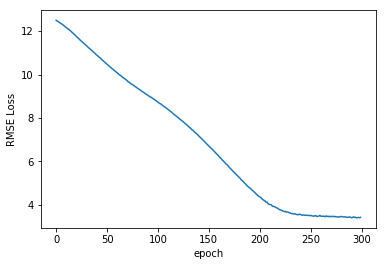

In [44]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [45]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.34590030


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [46]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   2.5379   2.9000   0.3621
 2.  25.1634   5.7000  19.4634
 3.   6.3749   7.7000   1.3251
 4.  13.4677  12.5000   0.9677
 5.   4.4992   4.1000   0.3992
 6.   4.8968   5.3000   0.4032
 7.   3.1796   3.7000   0.5204
 8.  17.7814  14.5000   3.2814
 9.   6.1348   5.7000   0.4348
10.  12.0325  10.1000   1.9325
11.   6.1323   4.5000   1.6323
12.   6.9208   6.1000   0.8208
13.   5.9448   6.9000   0.9552
14.  13.4625  14.1000   0.6375
15.   5.9277   4.5000   1.4277
16.  27.5778  34.1000   6.5222
17.   3.2774  12.5000   9.2226
18.   5.7506   4.1000   1.6506
19.   8.1940   8.5000   0.3060
20.   6.2858   5.3000   0.9858
21.  13.6693  11.3000   2.3693
22.   9.6759  10.5000   0.8241
23.  16.0568  15.3000   0.7568
24.  19.3310  14.9000   4.4310
25.  48.6873  49.5700   0.8827
26.   6.3257   5.3000   1.0257
27.   6.0392   3.7000   2.3392
28.   7.1921   6.5000   0.6921
29.  14.9567  14.1000   0.8567
30.   6.7476   4.9000   1.8476
31.   4.3447   3.7000   0.6447
32.  35.

So while many predictions were off by a few cents, some were off by \\$19.00. Feel free to change the batch size, test size, and number of epochs to obtain a better model.

## Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [47]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

In [2]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [3]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [4]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

## Feed new data through the trained model
For convenience, here are the max and min values for each of the variables:
<table style="display: inline-block">
<tr><th>Column</th><th>Minimum</th><th>Maximum</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>Use caution!</strong> The distance between 1 degree of latitude (from 40 to 41) is 111km (69mi) and between 1 degree of longitude (from -73 to -74) is 85km (53mi). The longest cab ride in the dataset spanned a difference of only 0.243 degrees latitude and 0.284 degrees longitude. The mean difference for both latitude and longitude was about 0.02. To get a fair prediction, use values that fall close to one another.

In [5]:
z = test_data(model2)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.9
What is the dropoff latitude?  40.52
What is the dropoff longitude? -73.92
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-15 16:00:00

The predicted fare amount is $13.86


## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Full Artificial Neural Network Code Along - CLASSIFICATION
In the last section we took in four continuous variables (lengths) to perform a classification. In this section we'll combine continuous and categorical data to perform a similar classification. The goal is to estimate the relative cost of a New York City cab ride from several inputs. The inspiration behind this code along is a recent <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>.

<div class="alert alert-success"><strong>NOTE:</strong> This notebook differs from the previous regression notebook in that it uses <tt>'fare_class'</tt> for the <tt><strong>y</strong></tt> set, and the output contains two values instead of one. In this exercise we're training our model to perform a binary classification, and predict whether a fare is greater or less than $10.00.</div>

## Working with tabular data
Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones. Make sure to watch the theory lectures! You'll want to be comfortable with:
* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

## Perform standard imports

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

Let's get started!

In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_class'].value_counts()

0    80000
1    40000
Name: fare_class, dtype: int64

Conveniently, 2/3 of the data have fares under \\$10, and 1/3 have fares \\$10 and above.

Fare classes correspond to fare amounts as follows:
<table style="display: inline-block">
<tr><th>Class</th><th>Values</th></tr>
<tr><td>0</td><td>< \$10.00</td></tr>
<tr><td>1</td><td>>= \$10.00</td></tr>
</table>

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Add a datetime column and derive useful statistics
By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc.
Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Separate categorical from continuous columns

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class']  # this column contains the labels

<div class="alert alert-info"><strong>NOTE:</strong> If you plan to use all of the columns in the data table, there's a shortcut to grab the remaining continuous columns:<br>
<pre style='background-color:rgb(217,237,247)'>cont_cols = [col for col in df.columns if col not in cat_cols + y_col]</pre>

Here we entered the continuous columns explicitly because there are columns we're not running through the model (fare_amount and EDTdate)</div>

## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [11]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

We can see that <tt>df['Hour']</tt> is a categorical feature by displaying some of the rows:

In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>


## Convert numpy arrays to tensors

In [20]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. We're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [21]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [22]:
conts.type()

'torch.FloatTensor'

Note: the CrossEntropyLoss function we'll use below expects a 1d y-tensor, so we'll replace <tt>.reshape(-1,1)</tt> with <tt>.flatten()</tt> this time.

In [23]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 0, 1, 0, 1])

In [24]:
cats.shape

torch.Size([120000, 3])

In [25]:
conts.shape

torch.Size([120000, 6])

In [26]:
y.shape

torch.Size([120000])

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [27]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

<div class="alert alert-info"><strong>Let's walk through the steps we're about to take. See below for more detailed illustrations of the steps.</strong><br>

1. Extend the base Module class, set up the following parameters:
   * <tt>emb_szs: </tt>list of tuples: each categorical variable size is paired with an embedding size
   * <tt>n_cont:  </tt>int: number of continuous variables
   * <tt>out_sz:  </tt>int: output size
   * <tt>layers:  </tt>list of ints: layer sizes
   * <tt>p:       </tt>float: dropout probability for each layer (for simplicity we'll use the same value throughout)
   
<tt><font color=black>class TabularModel(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self, emb_szs, n_cont, out_sz, layers, p=0.5):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Set up the embedded layers with <a href='https://pytorch.org/docs/stable/nn.html#modulelist'><tt><strong>torch.nn.ModuleList()</strong></tt></a> and <a href='https://pytorch.org/docs/stable/nn.html#embedding'><tt><strong>torch.nn.Embedding()</strong></tt></a><br>Categorical data will be filtered through these Embeddings in the forward section.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])</font></tt><br><br>
3. Set up a dropout function for the embeddings with <a href='https://pytorch.org/docs/stable/nn.html#dropout'><tt><strong>torch.nn.Dropout()</strong></tt></a> The default p-value=0.5<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.emb_drop = nn.Dropout(emb_drop)</font></tt><br><br>
4. Set up a normalization function for the continuous variables with <a href='https://pytorch.org/docs/stable/nn.html#batchnorm1d'><tt><strong>torch.nn.BatchNorm1d()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)</font></tt><br><br>
5. Set up a sequence of neural network layers where each level includes a Linear function, an activation function (we'll use <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong>ReLU</strong></a>), a normalization step, and a dropout layer. We'll combine the list of layers with <a href='https://pytorch.org/docs/stable/nn.html#sequential'><tt><strong>torch.nn.Sequential()</strong></tt></a><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.bn_cont = nn.BatchNorm1d(n_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_emb = sum((nf for ni,nf in emb_szs))<br>
&nbsp;&nbsp;&nbsp;&nbsp;n_in = n_emb + n_cont<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i in layers:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(n_in,i)) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.ReLU(inplace=True))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.BatchNorm1d(i))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Dropout(p))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;n_in = i<br>
&nbsp;&nbsp;&nbsp;&nbsp;layerlist.append(nn.Linear(layers[-1],out_sz))<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;self.layers = nn.Sequential(*layerlist)</font></tt><br><br>
6. Define the forward method. Preprocess the embeddings and normalize the continuous variables before passing them through the layers.<br>Use <a href='https://pytorch.org/docs/stable/torch.html#torch.cat'><tt><strong>torch.cat()</strong></tt></a> to combine multiple tensors into one.<br>
<tt><font color=black>def forward(self, x_cat, x_cont):<br>
&nbsp;&nbsp;&nbsp;&nbsp;embeddings = []<br>
&nbsp;&nbsp;&nbsp;&nbsp;for i,e in enumerate(self.embeds):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;embeddings.append(e(x_cat[:,i]))<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat(embeddings, 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.emb_drop(x)<br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;x_cont = self.bn_cont(x_cont)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = torch.cat([x, x_cont], 1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;x = self.layers(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return x</font></tt>
</div>

<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [28]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [29]:
# This is passed in when the model is instantiated
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [30]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [31]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [32]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.0347,  0.3536, -1.2988,  1.6375, -0.0542, -0.2099,  0.3044, -1.2855,
           0.8831, -0.7109, -0.9646, -0.1356],
         [-0.5039, -0.9924,  1.2296, -0.6908,  0.4641, -1.0487,  0.5577, -1.1560,
           0.8318, -0.0834,  1.2123, -0.6210],
         [ 0.3509,  0.2216,  0.3432,  1.4547, -0.8747,  1.6727, -0.6417, -1.0160,
           0.8217, -1.0531,  0.8357, -0.0637],
         [ 0.7978,  0.4566,  1.0926, -0.4095, -0.3366,  1.0216,  0.3601, -0.2927,
           0.3536,  0.2170, -1.4778, -1.1965]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.9676],
         [-0.9676],
         [-0.9676],
         [-1.0656]], grad_fn=<EmbeddingBackward>),
 tensor([[-2.1762,  1.0210,  1.3557, -0.1804],
         [-1.0131,  0.9989, -0.4746, -0.1461],
         [-1.0131,  0.9989, -0.4746, -0.1461],
         [-0.3646, -3.2237, -0.9956,  0.2598]], grad_fn=<EmbeddingBackward>)]

In [33]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.0347,  0.3536, -1.2988,  1.6375, -0.0542, -0.2099,  0.3044, -1.2855,
          0.8831, -0.7109, -0.9646, -0.1356, -0.9676, -2.1762,  1.0210,  1.3557,
         -0.1804],
        [-0.5039, -0.9924,  1.2296, -0.6908,  0.4641, -1.0487,  0.5577, -1.1560,
          0.8318, -0.0834,  1.2123, -0.6210, -0.9676, -1.0131,  0.9989, -0.4746,
         -0.1461],
        [ 0.3509,  0.2216,  0.3432,  1.4547, -0.8747,  1.6727, -0.6417, -1.0160,
          0.8217, -1.0531,  0.8357, -0.0637, -0.9676, -1.0131,  0.9989, -0.4746,
         -0.1461],
        [ 0.7978,  0.4566,  1.0926, -0.4095, -0.3366,  1.0216,  0.3601, -0.2927,
          0.3536,  0.2170, -1.4778, -1.1965, -1.0656, -0.3646, -3.2237, -0.9956,
          0.2598]], grad_fn=<CatBackward>)

In [34]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)

In [35]:
z = selfembdrop(z)
z

tensor([[ 0.0000,  0.0000, -2.1647,  0.0000, -0.0000, -0.3498,  0.5073, -2.1424,
          0.0000, -1.1848, -1.6076, -0.2259, -1.6127, -3.6271,  0.0000,  2.2594,
         -0.3007],
        [-0.8398, -0.0000,  0.0000, -0.0000,  0.7734, -1.7478,  0.0000, -1.9267,
          0.0000, -0.1390,  0.0000, -1.0350, -0.0000, -0.0000,  1.6648, -0.0000,
         -0.2435],
        [ 0.0000,  0.3693,  0.5719,  0.0000, -1.4578,  0.0000, -1.0694, -1.6933,
          0.0000, -1.7552,  1.3929, -0.1062, -1.6127, -1.6886,  1.6648, -0.0000,
         -0.0000],
        [ 1.3297,  0.0000,  0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.4879,
          0.0000,  0.0000, -2.4631, -1.9941, -1.7760, -0.6077, -5.3728, -1.6593,
          0.4330]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>This is how the categorical embeddings are passed into the layers.</strong></div>

In [36]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [37]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

In [38]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

## Define loss function & optimizer
For our classification we'll replace the MSE loss function with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll continue to use <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. To save time we'll use the first 60,000. Recall that our tensors are already randomly shuffled.

In [40]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [41]:
len(cat_train)

48000

In [42]:
len(cat_test)

12000

## Train the model
Expect this to take 30 minutes or more! We've added code to tell us the duration at the end.

In [43]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.73441482
epoch:  26  loss: 0.45090991
epoch:  51  loss: 0.35915938
epoch:  76  loss: 0.31940848
epoch: 101  loss: 0.29913244
epoch: 126  loss: 0.28824982
epoch: 151  loss: 0.28091952
epoch: 176  loss: 0.27713534
epoch: 201  loss: 0.27236161
epoch: 226  loss: 0.27171907
epoch: 251  loss: 0.26830241
epoch: 276  loss: 0.26365638
epoch: 300  loss: 0.25949642

Duration: 709 seconds


## Plot the loss function

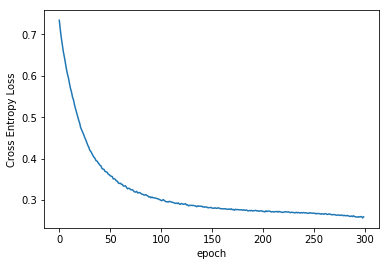

In [44]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Validate the model

In [45]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25455481


Now let's look at the first 50 predicted values

In [46]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 1.8140, -1.6443])    0      0   
tensor([-1.8268,  2.6373])    1      0   
tensor([ 1.4028, -1.9248])    0      0   
tensor([-1.9130,  1.4853])    1      1   
tensor([ 1.1757, -2.4964])    0      0   
tensor([ 2.0996, -2.2990])    0      0   
tensor([ 1.3226, -1.8349])    0      0   
tensor([-1.6211,  2.3889])    1      1   
tensor([ 2.2489, -2.4253])    0      0   
tensor([-0.4459,  1.1358])    1      1   
tensor([ 1.5145, -2.1619])    0      0   
tensor([ 0.7704, -1.9443])    0      0   
tensor([ 0.9637, -1.3796])    0      0   
tensor([-1.3527,  1.7322])    1      1   
tensor([ 1.4110, -2.4595])    0      0   
tensor([-1.4455,  2.6081])    1      1   
tensor([ 2.2798, -2.5864])    0      1   
tensor([ 1.4585, -2.7982])    0      0   
tensor([ 0.3342, -0.8995])    0      0   
tensor([ 2.0525, -1.9737])    0      0   
tensor([-1.3571,  2.1911])    1      1   
tensor([-0.4669,  0.2872])    1      1   
tensor([-2.0624,  2.2875])    1   

## Save the model
Save the trained model to a file in case you want to come back later and feed new data through it.

In [47]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareClssModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

In [2]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 2, [200,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [3]:
model2.load_state_dict(torch.load('TaxiFareClssModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [4]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts).argmax().item()
    print(f'\nThe predicted fare class is {z}')

## Feed new data through the trained model
For convenience, here are the max and min values for each of the variables:
<table style="display: inline-block">
<tr><th>Column</th><th>Minimum</th><th>Maximum</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>

<strong>Use caution!</strong> The distance between 1 degree of latitude (from 40 to 41) is 111km (69mi) and between 1 degree of longitude (from -73 to -74) is 85km (53mi). The longest cab ride in the dataset spanned a difference of only 0.243 degrees latitude and 0.284 degrees longitude. The mean difference for both latitude and longitude was about 0.02. To get a fair prediction, use values that fall close to one another.

In [5]:
test_data(model2)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.9
What is the dropoff latitude?  40.52
What is the dropoff longitude? -73.92
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-15 16:00:00

The predicted fare class is 1


Perfect! Where our regression predicted a fare value of ~\\$14, our binary classification predicts a fare greater than $10.
## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Neural Network Exercises
For these exercises we'll perform a binary classification on the Census Income dataset available from the <a href = 'http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a><br>
The goal is to determine if an individual earns more than $50K based on a set of continuous and categorical variables.

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Census Income Dataset
For this exercises we're using the Census Income dataset available from the <a href='http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a>.

The full dataset has 48,842 entries. For this exercise we have reduced the number of records, fields and field entries, and have removed entries with null values. The file <strong>income.csv</strong> has	30,000 entries

Each entry contains the following information about an individual:
* <strong>age</strong>: the age of an individual as an integer from 18 to 90 (continuous)
* <strong>sex</strong>: Male or Female (categorical)
* <strong>education</strong>: represents the highest level of education achieved by an individual (categorical)
* <strong>education_num</strong>: represents education as an integer from 3 to 16 (categorical)
<div><table style="display: inline-block">
<tr><td>3</td><td>5th-6th</td><td>8</td><td>12th</td><td>13</td><td>Bachelors</td></tr>
<tr><td>4</td><td>7th-8th</td><td>9</td><td>HS-grad</td><td>14</td><td>Masters</td></tr>
<tr><td>5</td><td>9th</td><td>10</td><td>Some-college</td><td>15</td><td>Prof-school</td></tr>
<tr><td>6</td><td>10th</td><td>11</td><td>Assoc-voc</td><td>16</td><td>Doctorate</td></tr>
<tr><td>7</td><td>11th</td><td>12</td><td>Assoc-acdm</td></tr>
</table></div>
* <strong>marital-status</strong>: marital status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Married</td><td>Divorced</td><td>Married-spouse-absent</td></tr>
<tr><td>Separated</td><td>Widowed</td><td>Never-married</td></tr>
</table></div>
* <strong>workclass</strong>: a general term to represent the employment status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Local-gov</td><td>Private</td></tr>
<tr><td>State-gov</td><td>Self-emp</td></tr>
<tr><td>Federal-gov</td></tr>
</table></div>
* <strong>occupation</strong>: the general type of occupation of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Adm-clerical</td><td>Handlers-cleaners</td><td>Protective-serv</td></tr>
<tr><td>Craft-repair</td><td>Machine-op-inspct</td><td>Sales</td></tr>
<tr><td>Exec-managerial</td><td>Other-service</td><td>Tech-support</td></tr>
<tr><td>Farming-fishing</td><td>Prof-specialty</td><td>Transport-moving</td></tr>
</table></div>
* <strong>hours-per-week</strong>: the hours an individual has reported to work per week as an integer from 20 to 90 (continuous)
* <strong>income</strong>: whether or not an individual makes more than \\$50,000 annually (label)
* <strong>label</strong>: income represented as an integer (0: <=\\$50K, 1: >\\$50K) (optional label)

## Perform standard imports
Run the cell below to load the libraries needed for this exercise and the Census Income dataset.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('../Data/income.csv')

In [2]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

### 1. Separate continuous, categorical and label column names
You should find that there are 5 categorical columns, 2 continuous columns and 1 label.<br>
In the case of <em>education</em> and <em>education-num</em> it doesn't matter which column you use. For the label column, be sure to use <em>label</em> and not <em>income</em>.<br>
Assign the variable names "cat_cols", "cont_cols" and "y_col" to the lists of names.

In [ ]:
df.columns

In [ ]:
# CODE HERE







# RUN THIS CODE TO COMPARE RESULTS:
print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

In [4]:
# DON'T WRITE HERE

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


### 2. Convert categorical columns to category dtypes

In [ ]:
# CODE HERE







In [5]:
# DON'T WRITE HERE

### Optional: Shuffle the dataset
The <strong>income.csv</strong> dataset is already shuffled. However, if you would like to try different configurations after completing the exercises, this is where you would want to shuffle the entire set.

In [ ]:
# THIS CELL IS OPTIONAL
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

### 3. Set the embedding sizes
Create a variable "cat_szs" to hold the number of categories in each variable.<br>
Then create a variable "emb_szs" to hold the list of (category size, embedding size) tuples.

In [ ]:
# CODE HERE




In [6]:
# DON'T WRITE HERE

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

### 4. Create an array of categorical values
Create a NumPy array called "cats" that contains a stack of each categorical column <tt>.cat.codes.values</tt><br>
Note: your output may contain different values. Ours came after performing the shuffle step shown above.

In [ ]:
# CODE HERE







# RUN THIS CODE TO COMPARE RESULTS
cats[:5]

In [7]:
# DON'T WRITE HERE

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

### 5. Convert "cats" to a tensor
Convert the "cats" NumPy array to a tensor of dtype <tt>int64</tt>

In [ ]:
# CODE HERE


In [8]:
# DON'T WRITE HERE

### 6. Create an array of continuous values
Create a NumPy array called "conts" that contains a stack of each continuous column.<br>
Note: your output may contain different values. Ours came after performing the shuffle step shown above.

In [ ]:
# CODE HERE


# RUN THIS CODE TO COMPARE RESULTS
conts[:5]

In [9]:
# DON'T WRITE HERE

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]], dtype=int64)

### 7. Convert "conts" to a tensor
Convert the "conts" NumPy array to a tensor of dtype <tt>float32</tt>

In [ ]:
# CODE HERE


# RUN THIS CODE TO COMPARE RESULTS
conts.dtype

In [10]:
# DON'T WRITE HERE

torch.float32

### 8. Create a label tensor
Create a tensor called "y" from the values in the label column. Be sure to flatten the tensor so that it can be passed into the CE Loss function.

In [ ]:
# CODE HERE


In [11]:
# DON'T WRITE HERE

### 9. Create train and test sets from <tt>cats</tt>, <tt>conts</tt>, and <tt>y</tt>
We use the entire batch of 30,000 records, but a smaller batch size will save time during training.<br>
We used a test size of 5,000 records, but you can choose another fixed value or a percentage of the batch size.<br>
Make sure that your test records remain separate from your training records, without overlap.<br>
To make coding slices easier, we recommend assigning batch and test sizes to simple variables like "b" and "t".

In [ ]:
# CODE HERE
b = 30000 # suggested batch size
t = 5000  # suggested test size







In [12]:
# DON'T WRITE HERE

### Define the model class
Run the cell below to define the TabularModel model class we've used before.

In [13]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

### 10. Set the random seed
To obtain results that can be recreated, set a torch manual_seed (we used 33).

In [ ]:
# CODE HERE


In [14]:
# DON'T WRITE HERE

### 11. Create a TabularModel instance
Create an instance called "model" with one hidden layer containing 50 neurons and a dropout layer p-value of 0.4

In [ ]:
# CODE HERE


# RUN THIS CODE TO COMPARE RESULTS
model

In [15]:
# DON'T WRITE HERE

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

### 12. Define the loss and optimization functions
Create a loss function called "criterion" using CrossEntropyLoss<br>
Create an optimization function called "optimizer" using Adam, with a learning rate of 0.001

In [ ]:
# CODE HERE




In [16]:
# DON'T WRITE HERE

### Train the model
Run the cell below to train the model through 300 epochs. Remember, results may vary!<br>
After completing the exercises, feel free to come back to this section and experiment with different parameters.

In [17]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.65308946
epoch:  26  loss: 0.54059124
epoch:  51  loss: 0.46917316
epoch:  76  loss: 0.41288978
epoch: 101  loss: 0.37744597
epoch: 126  loss: 0.35649022
epoch: 151  loss: 0.34338138
epoch: 176  loss: 0.33378774
epoch: 201  loss: 0.32601979
epoch: 226  loss: 0.32018784
epoch: 251  loss: 0.31548899
epoch: 276  loss: 0.30901730
epoch: 300  loss: 0.30690485

Duration: 170 seconds


### 13. Plot the Cross Entropy Loss against epochs
Results may vary. The shape of the plot is what matters.

In [ ]:
# CODE HERE




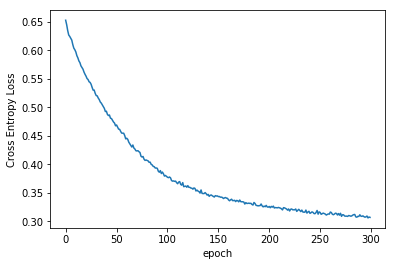

In [18]:
# DON'T WRITE HERE

### 14. Evaluate the test set
With torch set to <tt>no_grad</tt>, pass <tt>cat_test</tt> and <tt>con_test</tt> through the trained model. Create a validation set called "y_val". Compare the output to <tt>y_test</tt> using the loss function defined above. Results may vary.

In [ ]:
# CODE HERE




# RUN THIS CODE TO COMPARE RESULTS
print(f'CE Loss: {loss:.8f}')

In [19]:
# TO EVALUATE THE TEST SET

CE Loss: 0.30774996


### 15. Calculate the overall percent accuracy
Using a for loop, compare the argmax values of the <tt>y_val</tt> validation set to the <tt>y_test</tt> set.

In [ ]:
# CODE HERE







In [20]:
# DON'T WRITE HERE


4255 out of 5000 = 85.10% correct


### BONUS: Feed new data through the trained model
See if you can write a function that allows a user to input their own values, and generates a prediction.<br>
<strong>HINT</strong>:<br>There's no need to build a DataFrame. You can use inputs to populate column variables, convert them to embeddings with a context dictionary, and pass the embedded values directly into the tensor constructors:<br>
<pre>mar = input("What is the person's marital status? ")
mar_d = dict(Divorced=0, Married=1, Married-spouse-absent=2, Never-married=3, Separated=4, Widowed=5)
mar = mar_d[mar]
cats = torch.tensor([..., ..., mar, ..., ...], dtype=torch.int64).reshape(1,-1)</pre>
Make sure that names are put in alphabetical order before assigning numbers.

Also, be sure to run <tt>model.eval()</tt> before passing new date through. Good luck!

In [ ]:
# WRITE YOUR CODE HERE:


In [ ]:
# RUN YOUR CODE HERE:


In [21]:
# DON'T WRITE HERE

What is the person's age? (18-90)  22
What is the person's sex? (Male/Female) male
What is the person's education level? (3-16) 12
What is the person's marital status? married
What is the person's workclass? private
What is the person's occupation? sales
How many hours/week are worked? (20-90)  40

The predicted label is 0


## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Neural Network Exercises - SOLUTIONS
For these exercises we'll perform a binary classification on the Census Income dataset available from the <a href = 'http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a><br>
The goal is to determine if an individual earns more than $50K based on a set of continuous and categorical variables.

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Census Income Dataset
For this exercises we're using the Census Income dataset available from the <a href='http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a>.

The full dataset has 48,842 entries. For this exercise we have reduced the number of records, fields and field entries, and have removed entries with null values. The file <strong>income.csv</strong> has	30,000 entries

Each entry contains the following information about an individual:
* <strong>age</strong>: the age of an individual as an integer from 18 to 90 (continuous)
* <strong>sex</strong>: Male or Female (categorical)
* <strong>education</strong>: represents the highest level of education achieved by an individual (categorical)
* <strong>education_num</strong>: represents education as an integer from 3 to 16 (categorical)
<div><table style="display: inline-block">
<tr><td>3</td><td>5th-6th</td><td>8</td><td>12th</td><td>13</td><td>Bachelors</td></tr>
<tr><td>4</td><td>7th-8th</td><td>9</td><td>HS-grad</td><td>14</td><td>Masters</td></tr>
<tr><td>5</td><td>9th</td><td>10</td><td>Some-college</td><td>15</td><td>Prof-school</td></tr>
<tr><td>6</td><td>10th</td><td>11</td><td>Assoc-voc</td><td>16</td><td>Doctorate</td></tr>
<tr><td>7</td><td>11th</td><td>12</td><td>Assoc-acdm</td></tr>
</table></div>
* <strong>marital-status</strong>: marital status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Married</td><td>Divorced</td><td>Married-spouse-absent</td></tr>
<tr><td>Separated</td><td>Widowed</td><td>Never-married</td></tr>
</table></div>
* <strong>workclass</strong>: a general term to represent the employment status of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Local-gov</td><td>Private</td></tr>
<tr><td>State-gov</td><td>Self-emp</td></tr>
<tr><td>Federal-gov</td></tr>
</table></div>
* <strong>occupation</strong>: the general type of occupation of an individual (categorical)
<div><table style="display: inline-block">
<tr><td>Adm-clerical</td><td>Handlers-cleaners</td><td>Protective-serv</td></tr>
<tr><td>Craft-repair</td><td>Machine-op-inspct</td><td>Sales</td></tr>
<tr><td>Exec-managerial</td><td>Other-service</td><td>Tech-support</td></tr>
<tr><td>Farming-fishing</td><td>Prof-specialty</td><td>Transport-moving</td></tr>
</table></div>
* <strong>hours-per-week</strong>: the hours an individual has reported to work per week as an integer from 20 to 90 (continuous)
* <strong>income</strong>: whether or not an individual makes more than \\$50,000 annually (label)
* <strong>label</strong>: income represented as an integer (0: <=\\$50K, 1: >\\$50K) (optional label)

## Perform standard imports
Run the cell below to load the libraries needed for this exercise and the Census Income dataset.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

df = pd.read_csv('../Data/income.csv')

In [2]:
print(len(df))
df.head()

30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [3]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

### 1. Separate continuous, categorical and label column names
You should find that there are 5 categorical columns, 2 continuous columns and 1 label.<br>
In the case of <em>education</em> and <em>education-num</em> it doesn't matter which column you use. For the label column, be sure to use <em>label</em> and not <em>income</em>.<br>
Assign the variable names "cat_cols", "cont_cols" and "y_col" to the lists of names.

In [ ]:
df.columns

In [ ]:
# CODE HERE







# RUN THIS CODE TO COMPARE RESULTS:
print(f'cat_cols  has {len(cat_cols)} columns')
print(f'cont_cols has {len(cont_cols)} columns')
print(f'y_col     has {len(y_col)} column')

In [4]:
# DON'T WRITE HERE
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

print(f'cat_cols  has {len(cat_cols)} columns')  # 5
print(f'cont_cols has {len(cont_cols)} columns') # 2
print(f'y_col     has {len(y_col)} column')      # 1

cat_cols  has 5 columns
cont_cols has 2 columns
y_col     has 1 column


### 2. Convert categorical columns to category dtypes

In [ ]:
# CODE HERE







In [5]:
# DON'T WRITE HERE
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

### Optional: Shuffle the dataset
The <strong>income.csv</strong> dataset is already shuffled. However, if you would like to try different configurations after completing the exercises, this is where you would want to shuffle the entire set.

In [ ]:
# THIS CELL IS OPTIONAL
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

### 3. Set the embedding sizes
Create a variable "cat_szs" to hold the number of categories in each variable.<br>
Then create a variable "emb_szs" to hold the list of (category size, embedding size) tuples.

In [ ]:
# CODE HERE




In [6]:
# DON'T WRITE HERE
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

### 4. Create an array of categorical values
Create a NumPy array called "cats" that contains a stack of each categorical column <tt>.cat.codes.values</tt><br>
Note: your output may contain different values. Ours came after performing the shuffle step shown above.

In [ ]:
# CODE HERE







# RUN THIS CODE TO COMPARE RESULTS
cats[:5]

In [7]:
# DON'T WRITE HERE
sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx,ed,ms,wc,oc], 1)

cats[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

### 5. Convert "cats" to a tensor
Convert the "cats" NumPy array to a tensor of dtype <tt>int64</tt>

In [ ]:
# CODE HERE


In [8]:
# DON'T WRITE HERE
cats = torch.tensor(cats, dtype=torch.int64)

### 6. Create an array of continuous values
Create a NumPy array called "conts" that contains a stack of each continuous column.<br>
Note: your output may contain different values. Ours came after performing the shuffle step shown above.

In [ ]:
# CODE HERE


# RUN THIS CODE TO COMPARE RESULTS
conts[:5]

In [9]:
# DON'T WRITE HERE
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]], dtype=int64)

### 7. Convert "conts" to a tensor
Convert the "conts" NumPy array to a tensor of dtype <tt>float32</tt>

In [ ]:
# CODE HERE


# RUN THIS CODE TO COMPARE RESULTS
conts.dtype

In [10]:
# DON'T WRITE HERE
conts = torch.tensor(conts, dtype=torch.float)
conts.dtype

torch.float32

### 8. Create a label tensor
Create a tensor called "y" from the values in the label column. Be sure to flatten the tensor so that it can be passed into the CE Loss function.

In [ ]:
# CODE HERE


In [11]:
# DON'T WRITE HERE
y = torch.tensor(df[y_col].values).flatten()

### 9. Create train and test sets from <tt>cats</tt>, <tt>conts</tt>, and <tt>y</tt>
We use the entire batch of 30,000 records, but a smaller batch size will save time during training.<br>
We used a test size of 5,000 records, but you can choose another fixed value or a percentage of the batch size.<br>
Make sure that your test records remain separate from your training records, without overlap.<br>
To make coding slices easier, we recommend assigning batch and test sizes to simple variables like "b" and "t".

In [ ]:
# CODE HERE
b = 30000 # suggested batch size
t = 5000  # suggested test size







In [12]:
# DON'T WRITE HERE
b = 30000 # suggested batch size
t = 5000  # suggested test size

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

### Define the model class
Run the cell below to define the TabularModel model class we've used before.

In [13]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

### 10. Set the random seed
To obtain results that can be recreated, set a torch manual_seed (we used 33).

In [ ]:
# CODE HERE


In [14]:
# DON'T WRITE HERE
torch.manual_seed(33)

### 11. Create a TabularModel instance
Create an instance called "model" with one hidden layer containing 50 neurons and a dropout layer p-value of 0.4

In [ ]:
# CODE HERE


# RUN THIS CODE TO COMPARE RESULTS
model

In [15]:
# DON'T WRITE HERE
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

### 12. Define the loss and optimization functions
Create a loss function called "criterion" using CrossEntropyLoss<br>
Create an optimization function called "optimizer" using Adam, with a learning rate of 0.001

In [ ]:
# CODE HERE




In [16]:
# DON'T WRITE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model
Run the cell below to train the model through 300 epochs. Remember, results may vary!<br>
After completing the exercises, feel free to come back to this section and experiment with different parameters.

In [17]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.65308946
epoch:  26  loss: 0.54059124
epoch:  51  loss: 0.46917316
epoch:  76  loss: 0.41288978
epoch: 101  loss: 0.37744597
epoch: 126  loss: 0.35649022
epoch: 151  loss: 0.34338138
epoch: 176  loss: 0.33378774
epoch: 201  loss: 0.32601979
epoch: 226  loss: 0.32018784
epoch: 251  loss: 0.31548899
epoch: 276  loss: 0.30901730
epoch: 300  loss: 0.30690485

Duration: 170 seconds


### 13. Plot the Cross Entropy Loss against epochs
Results may vary. The shape of the plot is what matters.

In [ ]:
# CODE HERE




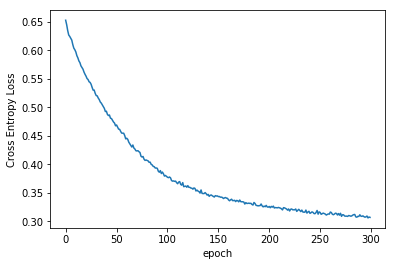

In [18]:
# DON'T WRITE HERE
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

### 14. Evaluate the test set
With torch set to <tt>no_grad</tt>, pass <tt>cat_test</tt> and <tt>con_test</tt> through the trained model. Create a validation set called "y_val". Compare the output to <tt>y_test</tt> using the loss function defined above. Results may vary.

In [ ]:
# CODE HERE




# RUN THIS CODE TO COMPARE RESULTS
print(f'CE Loss: {loss:.8f}')

In [19]:
# TO EVALUATE THE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.30774996


### 15. Calculate the overall percent accuracy
Using a for loop, compare the argmax values of the <tt>y_val</tt> validation set to the <tt>y_test</tt> set.

In [ ]:
# CODE HERE







In [20]:
# DON'T WRITE HERE
rows = len(y_test)
correct = 0

# print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):
    # print(f'{str(y_val[i]):26} {y_val[i].argmax().item():^7}{y_test[i]:^7}')

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4255 out of 5000 = 85.10% correct


### BONUS: Feed new data through the trained model
See if you can write a function that allows a user to input their own values, and generates a prediction.<br>
<strong>HINT</strong>:<br>There's no need to build a DataFrame. You can use inputs to populate column variables, convert them to embeddings with a context dictionary, and pass the embedded values directly into the tensor constructors:<br>
<pre>mar = input("What is the person's marital status? ")
mar_d = dict(Divorced=0, Married=1, Married-spouse-absent=2, Never-married=3, Separated=4, Widowed=5)
mar = mar_d[mar]
cats = torch.tensor([..., ..., mar, ..., ...], dtype=torch.int64).reshape(1,-1)</pre>
Make sure that names are put in alphabetical order before assigning numbers.

Also, be sure to run <tt>model.eval()</tt> before passing new date through. Good luck!

In [ ]:
# WRITE YOUR CODE HERE:


In [ ]:
# RUN YOUR CODE HERE:


In [21]:
# DON'T WRITE HERE
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)

What is the person's age? (18-90)  22
What is the person's sex? (Male/Female) male
What is the person's education level? (3-16) 12
What is the person's marital status? married
What is the person's workclass? private
What is the person's occupation? sales
How many hours/week are worked? (20-90)  40

The predicted label is 0


## Great job!

<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Saving and Loading Trained Models
Refer back to this notebook as a refresher on saving and loading models.

## Saving a trained model
Save a trained model to a file in case you want to come back later and feed new data through it.


To save a trained model called "model" to a file called "MyModel.pt":

In [ ]:
torch.save(model.state_dict(), 'MyModel.pt')

To ensure the model has been trained before saving (assumes the variables "losses" and "epochs" have been defined):

In [ ]:
if len(losses) == epochs:
    torch.save(model.state_dict(), 'MyModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions.

### 1. Perform standard imports
These will depend on the scope of the model, chosen displays, metrics, etc.

In [ ]:
# Perform standard imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

### 2. Run the model definition
We'll introduce the model shown below in the next section.

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

### 3. Instantiate the model, load parameters
First we instantiate the model, then we load the pre-trained weights & biases, and finally we set the model to "eval" mode to prevent any further backprops.

In [ ]:
model2 = MultilayerPerceptron()
model2.load_state_dict(torch.load('MyModel.pt'));
model2.eval() # be sure to run this step!

## That's it!
Toward the end of the CNN section we'll show how to import a trained model and adapt it to a new set of image data.